In [47]:
#todo KNN imputation if the missing rate is high.
#todo Create new features that may capture underlying patterns (e.g., interaction terms, polynomial features).
#todo create separate file for data preparation

In [48]:
##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from TargetEncoder import TargetEncoder
from xgboost import XGBRegressor

In [49]:
warnings.filterwarnings('ignore')

In [50]:
##
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

In [51]:
##
submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
print(train.shape)

(750000, 12)


In [52]:
drop_cols = ['id']
target_col = ['Listening_Time_minutes']
cat_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = [col for col in train.columns if col not in drop_cols + cat_cols + target_col]

In [53]:
train.shape

(750000, 12)

# Data Cleaning and Preprocessing
 

In [54]:
def target_encoder(df_train, y_train, df_test, cols, enc):
    for col in cols:
        df_train.loc[:, col] = enc.fit_transform(df_train.loc[:, col], y_train).reshape(-1)
        df_test.loc[:, col] = enc.transform(df_test.loc[:, col]).reshape(-1)
    df_train[cols] = df_train[cols].apply(pd.to_numeric, errors='coerce')
    df_test[cols] = df_test[cols].apply(pd.to_numeric, errors='coerce')

    return df_train, df_test

In [55]:
def pipe(numer_type_cols, cat_type_cols):
    
    # Define transformers
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Mean imputation
        ("scaler", StandardScaler())  # Standard scaling
    ])
    
    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ("num", num_pipeline, numer_type_cols),
        ("cat", cat_pipeline, cat_type_cols)
    ])
    return preprocessor


# Baseline Model:

In [56]:
X = train.drop(drop_cols + target_col, axis=1)
y = train['Listening_Time_minutes']

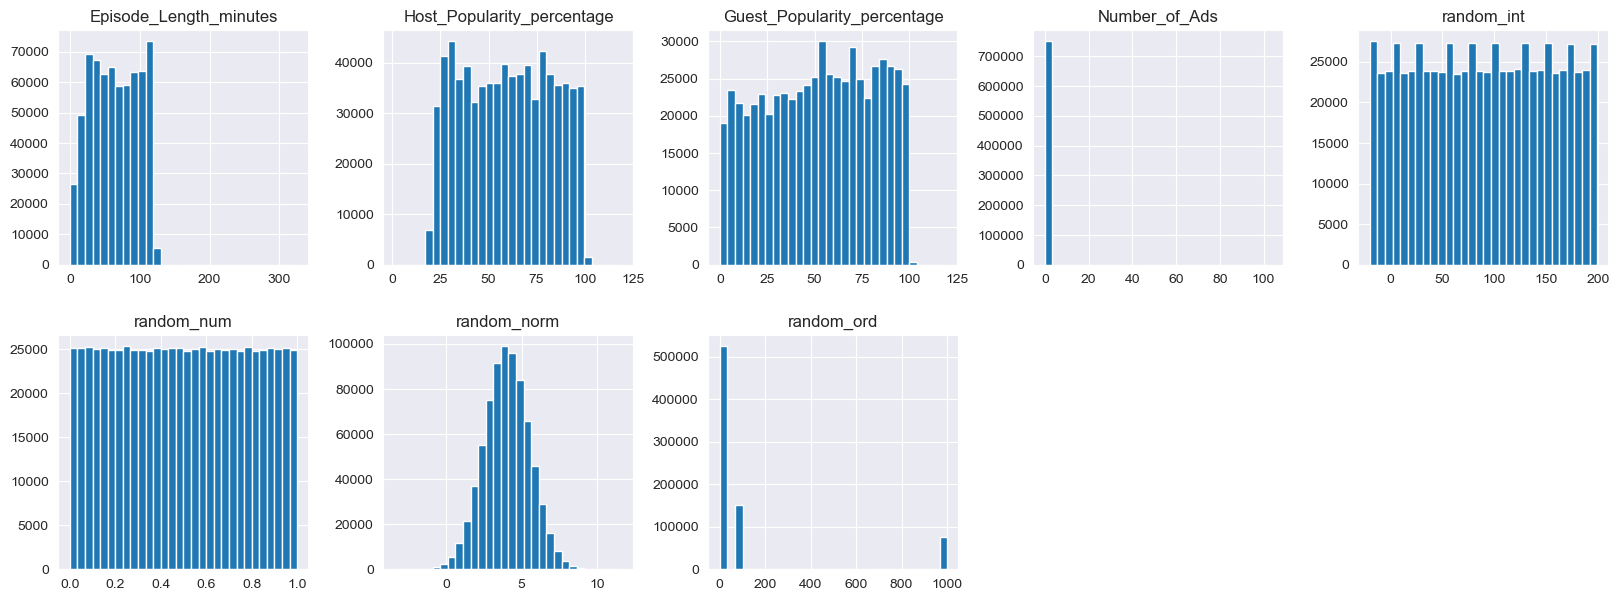

In [57]:
X['random_int'] = np.random.randint(-20, 200, X.shape[0]) # Целочисленный признак
X['random_num'] = np.random.random(size = X.shape[0]) # Признак типа float с равномерным распределением
X['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = X.shape[0]) # Признак с нормальным распределением
X['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = X.shape[0]) # Категориальный признак str формата с дисбалансом
X['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = X.shape[0]) # Численный категориальный признак

X.hist(figsize = (20, 7), layout = (-1, 5), bins=30);

In [58]:
enc = TargetEncoder()
X, X_test = target_encoder(X, y, test, ['Podcast_Name', 'Episode_Title'], enc)

In [59]:
numer_type_cols = X.select_dtypes(include=["number"]).columns
cat_type_cols = X.select_dtypes(include=["object"]).columns

In [60]:
preprocessor = pipe(numer_type_cols, cat_type_cols)

In [61]:
# Define full pipeline with Linear Regression
baseline_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42))
])

In [62]:
outliers = 'Episode_Length_minutes > 140 or Number_of_Ads > 3'
index_drop = X.query(outliers).index
X.drop(index_drop, inplace=True)
y.drop(index_drop, inplace=True)

In [63]:
baseline_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Host_Popularity_percentage', 'Guest_Popularity_percentage',
       'Number_of_Ads', 'random_int', 'random_num', 'random_norm',
       'random_or...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

# Feature importances

In [64]:
def plot_importance(importance_df, title="Feature Importance"):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

In [65]:
model = baseline_pipeline.named_steps['model']
not_transformed = baseline_pipeline.named_steps['preprocessor'].transformers_[0][2]
transformed_columns = baseline_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps[
    'encoder'].get_feature_names_out(input_features=X[cat_type_cols].columns)
all_cols = np.concatenate([not_transformed, transformed_columns])

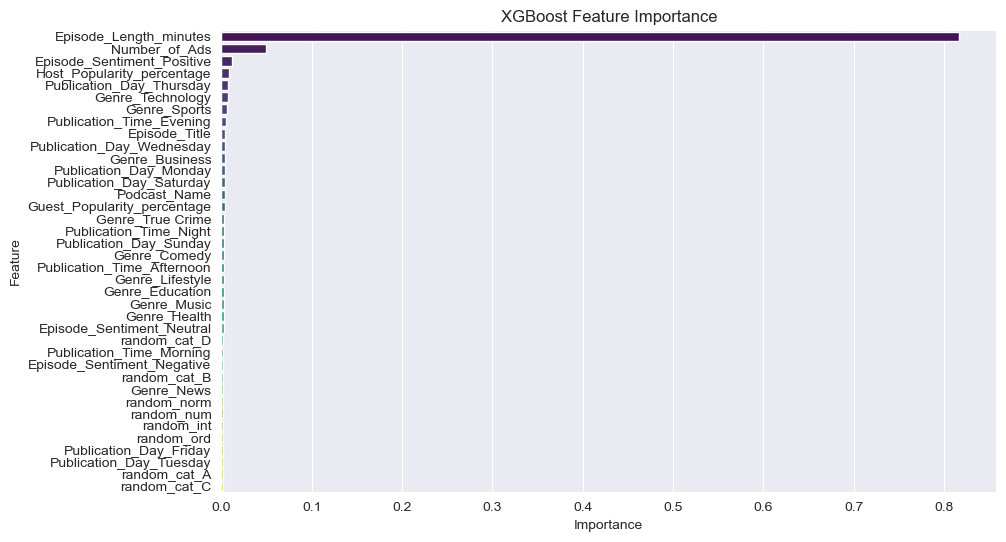

In [66]:
xgb_importance = pd.DataFrame({
    "Feature": all_cols,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)
plot_importance(xgb_importance, "XGBoost Feature Importance")

In [67]:
X_train, _, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

enc = TargetEncoder()
X_train, X_test = target_encoder(X_train, y_train, X_test, ['Podcast_Name', 'Episode_Title'], enc)
preprocessor = pipe(numer_type_cols, cat_type_cols)
X_train = preprocessor.fit_transform(X_train)


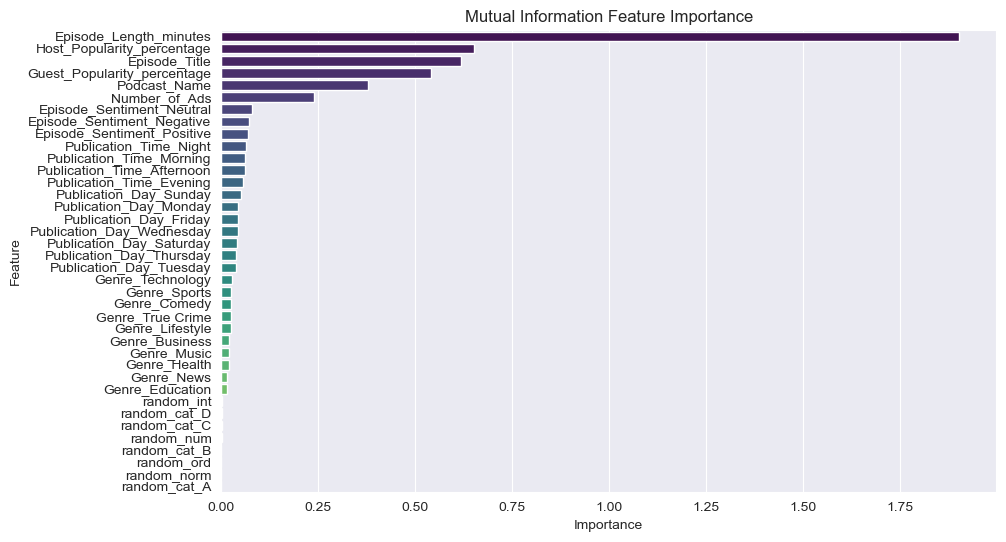

In [68]:
# 📌 4️⃣ Statistical Test - Mutual Information
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, y_train)
mi_importance = pd.DataFrame({
    "Feature": all_cols,
    "Importance": mi_scores
}).sort_values(by="Importance", ascending=False)
plot_importance(mi_importance, "Mutual Information Feature Importance")

In [69]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

enc = TargetEncoder()
X_train, X_test = target_encoder(X_train, y_train, X_test, ['Podcast_Name', 'Episode_Title'], enc)
preprocessor = pipe(numer_type_cols, cat_type_cols)
X_train = preprocessor.fit_transform(X_train)


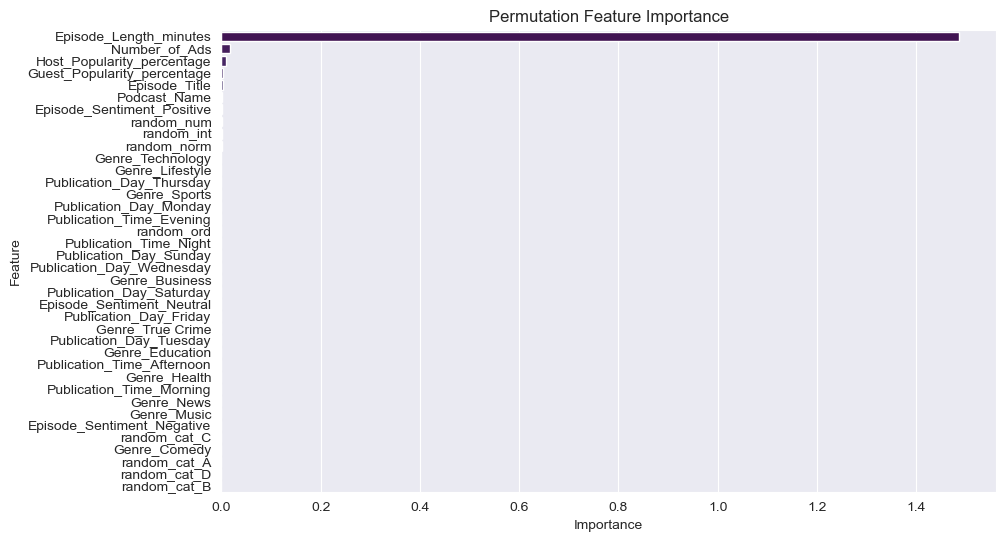

In [70]:
# 📌 5️⃣ Permutation Importance (Shuffling Feature Values)
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    "Feature": all_cols,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
plot_importance(perm_importance_df, "Permutation Feature Importance")

<Axes: >

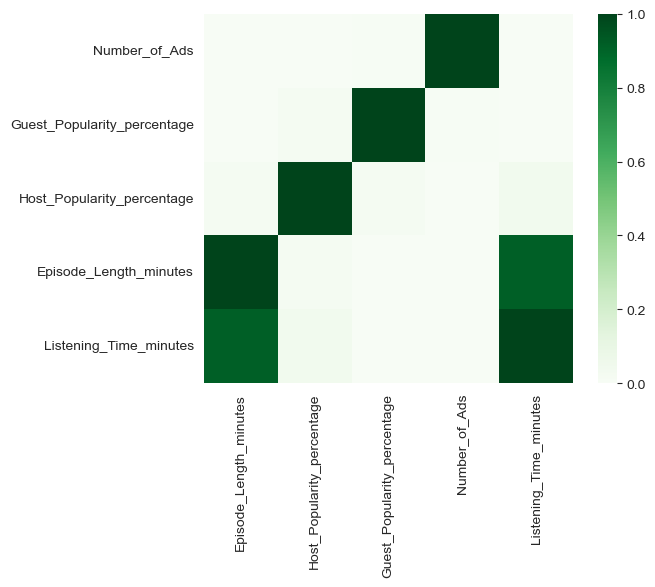

In [72]:
corrs = train.dropna().drop(columns=['id']).corr(numeric_only=True).round(3).sort_values('Listening_Time_minutes')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

In [73]:
from phik.report import plot_correlation_matrix

interval columns not set, guessing: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']


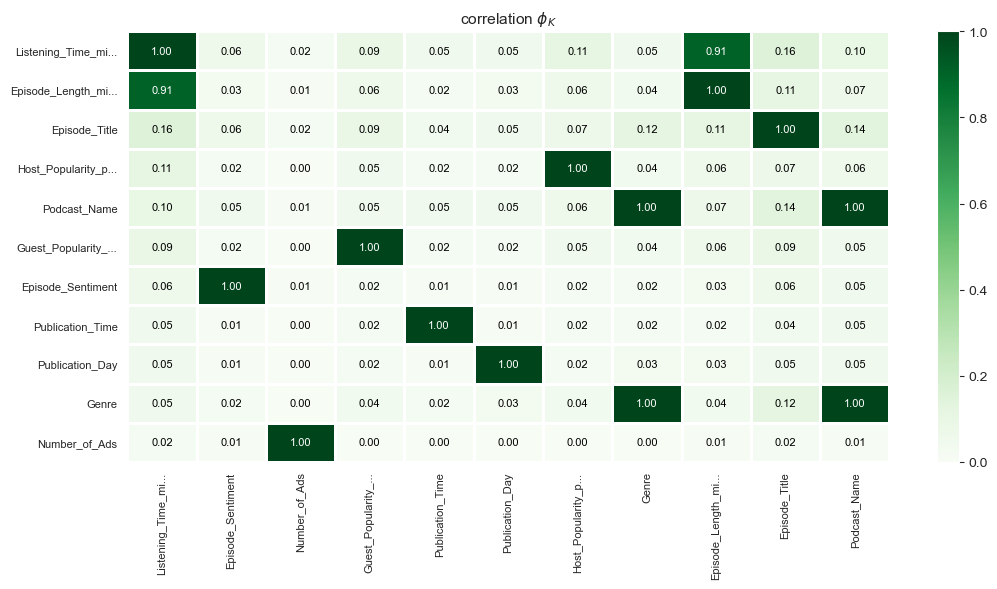

In [74]:
phik_overview = train.dropna().drop(columns=['id']).phik_matrix().round(2).sort_values('Listening_Time_minutes')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()